# Document Clustering

In this notebook I attempt to cluster a set of documents posted on newsgroups using simple clustering mechanisms and feature extraction. The corpus is made up of 300 documents, each of which is characterised at least by some body text, and the newsgroups which it was posted in.

## Prelim: Importing libraries

First, run the below code to import. Only uncomment the BERT serving client if you want to run my BERT code (shown in Appendix).

In [1]:
%matplotlib inline  

import glob
import re
import numpy as np
import pickle
import math
import pprint
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.stem.porter import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# from bert_serving.client import BertClient


## Part 1: Extracting features

I extracted features in 3 ways. The most effective method was actually the simplest, that being completely ignoring the body text of the document and encoding only the newsgroup categories of the document. For later topic analysis, however, I use the body text, and for efficiency I extract it here. This is done in the below code:

### Extra:

If we want to weight the newsgroup counts to have different degrees of importance (based on how often they appear in documents) we can use tf-idf. I build dictionaries for this below, though I don't use them later in the process.

In [2]:
# define dictionaries

tf = {}
df = {}
cleaned_dict = {}
cleaned_sentences = {}
email_ng = {}
ng_set_total = set()

# get files

files = glob.glob('../data/*')
# define function for removing punctuation from body text

def clean_text(original_text):
    cleaned = re.sub('[!/\'\"(),.:#>-@*\n]',' ', original_text)
    return cleaned

for file in files:
    tf[file] = {}
    with open(file,'r', encoding="utf8", errors='ignore') as input:

        text = input.read()

        # get the newsgroup words and process them

        newsgroup_match = re.search('Newsgroups: (.+)', text).group(1)
        newsgroups = newsgroup_match.split(',')
        ng_words = []
        
        for group in newsgroups:
            subgroups = group.split('.')
            ng_words.extend(subgroups)
        
        # some newsgroups e.g. 'talk' are repeated often -- we only need one of each tag
        # therefore make it a set.
        
        ng_set = list(set(ng_words))
        email_ng[file] = ng_set
        for element in ng_set:
            ng_set_total.add(element)
 
        # now extract and clean body text
            
        body_text = re.search(r'\n\n((.|\n)+)$', text).group()
        cleaned = clean_text(body_text) # + ' ' + subject_match
        cleaned_sentences[file] = cleaned.lower()
        cleaned_sentences_list = cleaned.lower()
        
        for ng in ng_set:
            try:
                tf[file][ng] += 1
            except KeyError:
                tf[file][ng] = 1

        for ng in ng_set_total:
            try:
                df[ng] += 1
            except KeyError:
                df[ng] = 1


Now build a one-hot encoding for each document representing the newsgroups of each doc.

In [3]:
points = []
new_files = []

# give each newsgroup a numerical value

ng2idx = {ng:idx for idx, ng in enumerate(ng_set_total)}
total_ngs = len(ng_set_total)

# encode each file

for file, ngs in email_ng.items():
    encoding = np.zeros(total_ngs)
    for ng in ngs:
        encoding[ng2idx[ng]] = 1
        # comment out above and uncomment below to give sentence vectors tf-idf weighting.
        # encoding[ng2idx[ng]] = math.log(tf[file][ng]+1,10)*math.log(300/df[ng],10)
    points.append(encoding)
    new_files.append(file)
    
files = new_files

## Section 2: Clustering the documents

In this section we take the one-hot encoded documents and cluster them. This is done using a simple implementation of mean-shift clustering, in which we hill-climb to the highest density  point in n-dimensional space from each encoded document.

In [4]:
# make a copy of the encodings -- this will be the initial 'mean' for each of the original points

points_copy = points.copy()
dimension = 120

# list of final cluster centres

cluster_centres = []

for point in points_copy:
    is_stable = False
    # initialise theorised cluster point at an original encoding
    current_point = point
    while is_stable == False:
        update = np.zeros(dimension)
        n = 0
        # search throughout all original points
        for original_point in points:
            # if original point is within a certain distance of the theorised cluster point
            # then include in update.
            if np.linalg.norm(current_point - original_point) < 2.25:
                update += original_point
                n += 1
        # mean of all included points is the new theorised cluster point
        new_point = update/n
        # stop iterating if new theorised cluster point is identical to the current theorised cluster point
        if (new_point == current_point).all():
            is_stable = True
        current_point = new_point
    cluster_centres.append(current_point)

This now gives us a the centre of the cluster to which each encoded document belongs. Note that there is one parameter that must be chosen in this process -- the distance parameter. This parameter decides which original points are included in the recalculation of the cluster centre. I found an ideal value through trial and error.

Now that we have a cluster centre for each document in the corpus, we can assign each document to a cluster. All documents with the same cluster centre can be said to come from the same cluster. This is done in the below code.

Printed below are the 'clusters', and the files that comprise them. A cluster here must be comprised of at least one datapoint.

In [9]:
cluster_bank = []
cluster_names = []
cluster_to_file = {}
cluster_counter = 0

for i, centroid in enumerate(cluster_centres):
    # check if the cluster centre doesn't already exist in the cluster bank
    if not any((centroid == x).all() for x in cluster_bank):
        cluster_counter += 1
        cluster_name = 'cluster_'+str(cluster_counter)
        cluster_bank.append(centroid)
        cluster_names.append(cluster_name)
        cluster_to_file[cluster_name] = [files[i]]
    # if cluster centre is in bank, get cluster name and assign it to the document
    else:
        lst = [(centroid == x).all() for x in cluster_bank]
        idx = lst.index(True)
        cluster_name = cluster_names[idx]
        cluster_to_file[cluster_name].append(files[i])
        
pprint.pprint(cluster_to_file)

{'cluster_1': ['../data/38402',
               '../data/38606',
               '../data/38853',
               '../data/38699',
               '../data/38264',
               '../data/38636',
               '../data/38459',
               '../data/38466',
               '../data/38839',
               '../data/38380',
               '../data/38942',
               '../data/38788',
               '../data/38571',
               '../data/38929',
               '../data/38386',
               '../data/38375',
               '../data/38921',
               '../data/39663',
               '../data/39664',
               '../data/37942',
               '../data/39017',
               '../data/38758',
               '../data/38904',
               '../data/39072',
               '../data/38968',
               '../data/39615',
               '../data/37916',
               '../data/39027',
               '../data/38750',
               '../data/38562',
               '../data/37944',
        

### Analysis:

My clustering algorithm reports three major document clusters. There are other, small, clusters, although they are of such low document count it seems more justifiable to treat them as outliers.

## Section 3: Topic analysis of each cluster

### Normalisation

Now that we have clusters, we can find the topic of each cluster. I use Latent Dirichlet Allocation to perform topic modelling on the body text of each cluster. This requires building a bag of words model to represent each document in the corpus. To make this easier, we stemmatise and lemmatise all words. The functions for preprocessing the body text is shown below.

In [6]:
stemmer = SnowballStemmer('english')

def process_tokens(token):
    if len(token) > 3 and token not in STOPWORDS:
        stemmed = stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
    else:
        stemmed = ''
    return stemmed

### Topic analysis

Below is the code which performs topic analysis. I only attempt to divine the topics of clusters that have at least 10 documents. For each cluster, I create the bag of words for each document. I then use the gensim library's LDA function to find the topic that best defines the cluster.

This code is largely inspired by a tutorial on Latent Dirichlet Allocation (https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24).

In [12]:
n = 1

for cluster, files in cluster_to_file.items():
    
    # get files from clusters w more than 10 entries
    if len(files) < 10:
        continue
    corpus = [cleaned_sentences[file] for file in files]
    
    # process files in cluster
    stemmed_sentences = []
    for words in corpus:
        words = words.split()
        new_sentence = ' '.join([process_tokens(word) for word in words]).split()
        stemmed_sentences.append(new_sentence)
        
    # perform lda analysis by building idx dictionary for each word, creating bag of words model
    # and training the lda model
    dictionary = gensim.corpora.Dictionary(stemmed_sentences)
    new_corpus = [dictionary.doc2bow(doc) for doc in stemmed_sentences]
    lda_model = gensim.models.ldamodel.LdaModel(new_corpus, num_topics=1, id2word=dictionary, passes=5)
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(n, topic))
        n+=1

Topic: 1 
Words: 0.015*"imag" + 0.007*"data" + 0.006*"graphic" + 0.005*"program" + 0.005*"file" + 0.005*"avail" + 0.004*"format" + 0.004*"line" + 0.004*"packag" + 0.004*"display"
Topic: 2 
Words: 0.007*"write" + 0.007*"peopl" + 0.006*"articl" + 0.005*"know" + 0.004*"weapon" + 0.004*"gun" + 0.004*"right" + 0.004*"think" + 0.004*"like" + 0.003*"govern"
Topic: 3 
Words: 0.009*"write" + 0.008*"stephanopoulo" + 0.007*"think" + 0.007*"articl" + 0.007*"say" + 0.006*"peopl" + 0.006*"presid" + 0.005*"know" + 0.004*"govern" + 0.004*"go"


### Analysis

It seems that some of the clusters are very distinct, while others are very similar. Notably, one cluster seems to be about computers, while the others seem to be about politics. There is notable overlap in the 'political' clusters, with both groups being defined by words like 'govern'. However, the differences seem to imply each cluster represents a different political topic -- such as gun rights.

## Section 4: Cluster visualisation

To perform cluster visualisation, I apply T-SNE to the encoded documents. This projects the encodings into two-dimensional space, where they can be plotted. I colour each point by the cluster group it is a member of, or I colour it black if it is not a member of a large cluster.

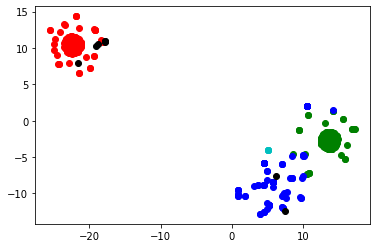

In [14]:
files = new_files

two_dim_rep = TSNE().fit_transform(points)
x, y = zip(*list(two_dim_rep))

colours= ['r','g','b','c','y']

col = 0

for cluster, clustered_files in cluster_to_file.items():
    idxs = []
    for file in clustered_files:
        idx = files.index(file)
        idxs.append(idx)
    xs = [x[i] for i in idxs]
    ys = [y[i] for i in idxs]
    if len(clustered_files) < 4:
        plt.scatter(xs, ys, c = 'black')
    else:
        plt.scatter(xs, ys, c = colours[col])
        col+=1
plt.show()

### Analysis

This supports the analysis suggested by the topic analysis. As can be seen on the scatterplot, one cluster (that relating to computer graphics) is very separate from the other, politics based clusters. Indeed, although the politics clusters do appear to have some degree of separation, they clearly overlap. Whether this suggests that the dataset is characterised by 2 clusters rather than 3 is a somewhat subjective distinction. What one can say through the analysis conducted so far is that there are *at least* two document clusters in the corpus.

# Appendix

Below are some alternative methods I used for encoding the sentences. By running the below code, and changing the size of the dimension variable in Section 2, the code should be able to be run as normal with these changed encodings.

### Extra

I tried BERT encoding the body text of the documents. This actually produced worse results, but if this is something you would like to try using my code, I used BERT-as-a-service to encode the documents. The below code encodes the sentences using this methodology:

In [ ]:
points = bc.encode(cleaned_sentences_list)

### Extra

I also encoded the sentences by taking the average of all the GloVe word embeddings. Below is the code to do this. I used GloVe with 100 dimension word vectors trained on Wikipedia.

In [ ]:
glove = {}
points = []
vecs = np.zeros((400000, 100), dtype=np.float32)

with open('../glove.6b/glove.6B.100d.txt','r',encoding='utf8') as dictionary:
    for i, line in enumerate(dictionary):

        split = line.split()
        word = split[0]
        vector = np.asarray(split[1:], "float32")
        glove[word] = vector
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

glove['<UNK>'] = np.mean(vecs, axis=0)

# part of above solution taken from https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt

for file in cleaned_sentences.keys():
    words = cleaned_sentences[file]
    word_vectors = []
    for word in words:
        try:
            word_vectors.append(glove[word])
        except KeyError:
            word_vectors.append(glove['<UNK>'])
    word_vectors = np.asarray(word_vectors)
    tf_idf = np.asarray([word for word in words])
    points.append(np.average(word_vectors, axis = 0))
